In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from sklearn.metrics import confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=4)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000023B09436680>
Traceback (most recent call last):
  File "d:\ip_ai_21\venv\lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "d:\ip_ai_21\venv\lib\site-packages\torch\utils\data\dataloader.py", line 1435, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Files already downloaded and verified
Files already downloaded and verified


In [27]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(net.parameters())

In [40]:
# Обучение модели
num_epochs = 10
train_loss_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device)  # <-- Важный шаг

        optimizer.zero_grad()

        outputs = net(inputs) 
        loss = criterion(outputs, labels)  

        loss.backward()  
        optimizer.step()

        running_loss += loss.item()

    train_loss_list.append(running_loss / len(trainloader))
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.3f}")

print('Training Finished')


Epoch 1, Loss: 0.000
Epoch 2, Loss: 0.000
Epoch 3, Loss: 0.000
Epoch 4, Loss: 0.000
Epoch 5, Loss: 0.000
Epoch 6, Loss: 0.000
Epoch 7, Loss: 0.000
Epoch 8, Loss: 0.000
Epoch 9, Loss: 0.000
Epoch 10, Loss: 0.000
Training Finished


Accuracy of the network on the 10000 test images: 75.11%


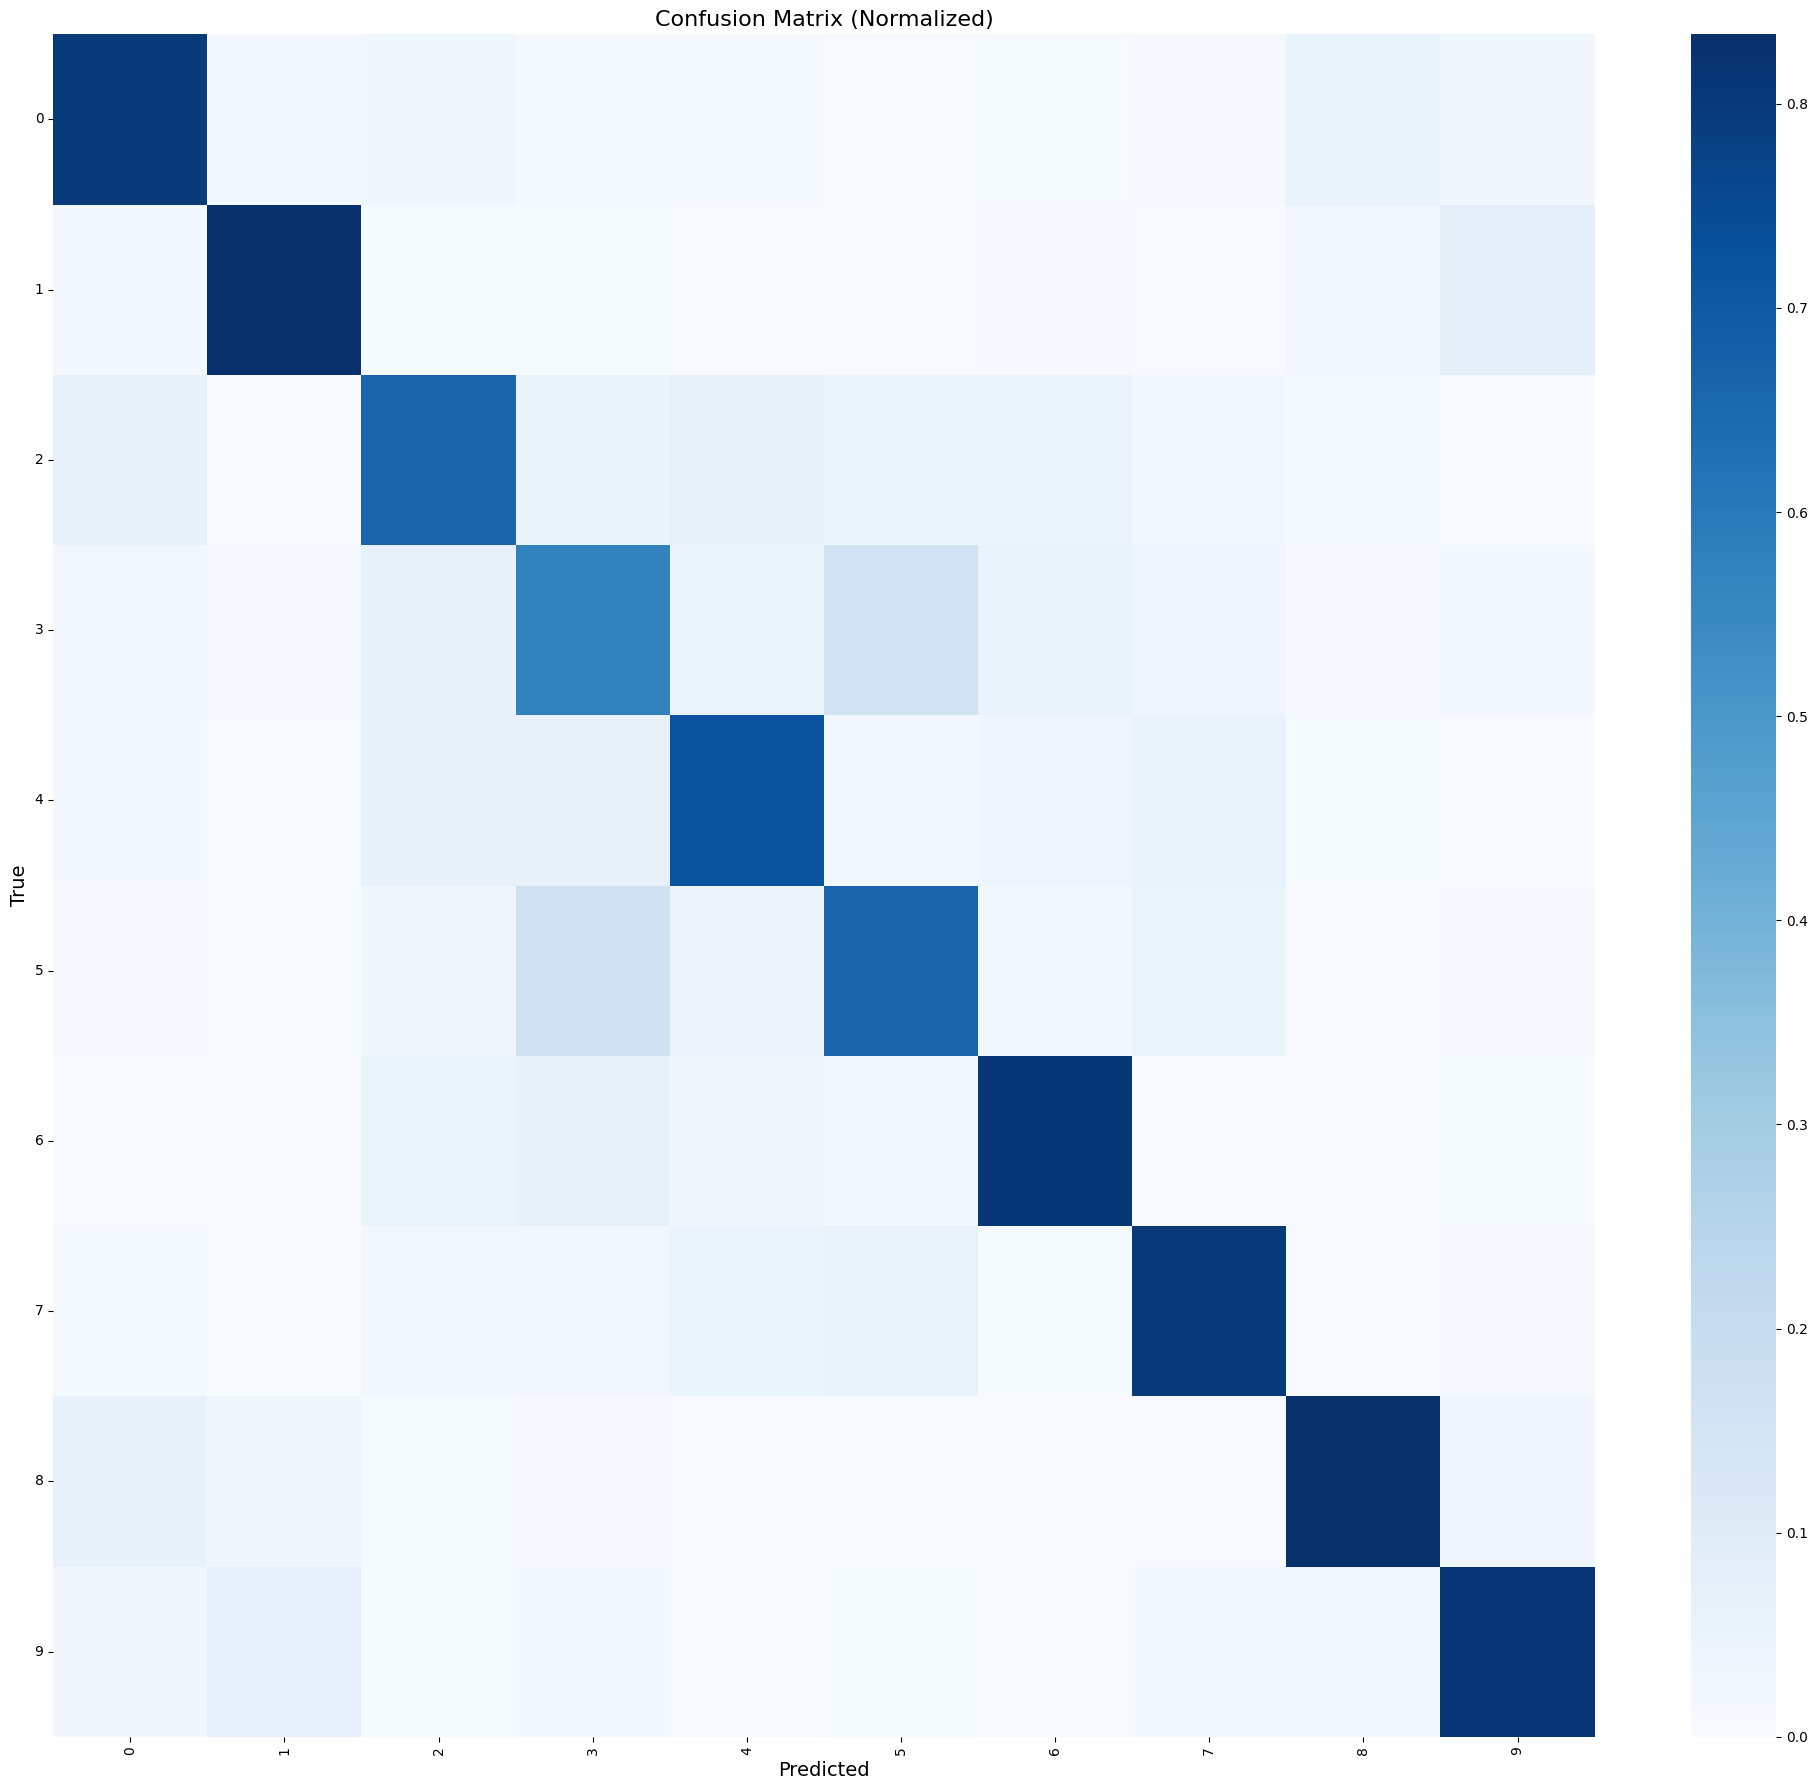

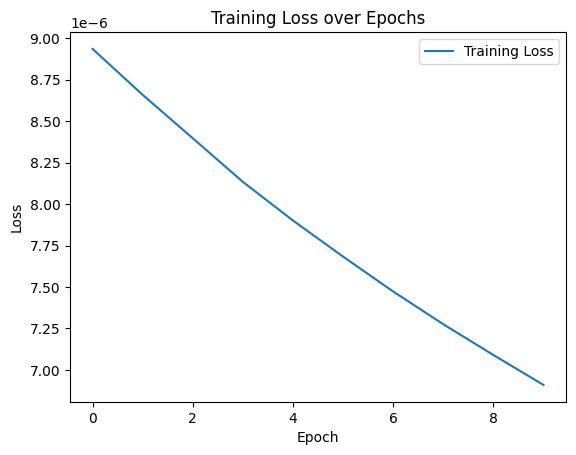

In [45]:
correct = 0
total = 0
all_predictions = []
all_labels = []
num_classes = 10

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_predictions.extend(predicted.cpu().numpy())  # Сохранение предсказаний
        all_labels.extend(labels.cpu().numpy())

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 18))
sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues', cbar=True)

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix (Normalized)', fontsize=16)

plt.xticks(np.arange(num_classes) + 0.5, labels=np.arange(num_classes), rotation=90, fontsize=10)
plt.yticks(np.arange(num_classes) + 0.5, labels=np.arange(num_classes), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


dataiter = iter(testloader)
images, labels = next(dataiter)